# BiLSTM with Attention Mechanism
- IMDB 리뷰 data로 감성 분류

## 1. Import Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
(X_train,y_train), (X_test,y_test) = imdb.load_data(num_words=vocab_size)

In [3]:
X_train[10]

[1,
 785,
 189,
 438,
 47,
 110,
 142,
 7,
 6,
 7475,
 120,
 4,
 236,
 378,
 7,
 153,
 19,
 87,
 108,
 141,
 17,
 1004,
 5,
 2,
 883,
 2,
 23,
 8,
 4,
 136,
 2,
 2,
 4,
 7475,
 43,
 1076,
 21,
 1407,
 419,
 5,
 5202,
 120,
 91,
 682,
 189,
 2818,
 5,
 9,
 1348,
 31,
 7,
 4,
 118,
 785,
 189,
 108,
 126,
 93,
 2,
 16,
 540,
 324,
 23,
 6,
 364,
 352,
 21,
 14,
 9,
 93,
 56,
 18,
 11,
 230,
 53,
 771,
 74,
 31,
 34,
 4,
 2834,
 7,
 4,
 22,
 5,
 14,
 11,
 471,
 9,
 2,
 34,
 4,
 321,
 487,
 5,
 116,
 15,
 6584,
 4,
 22,
 9,
 6,
 2286,
 4,
 114,
 2679,
 23,
 107,
 293,
 1008,
 1172,
 5,
 328,
 1236,
 4,
 1375,
 109,
 9,
 6,
 132,
 773,
 2,
 1412,
 8,
 1172,
 18,
 7865,
 29,
 9,
 276,
 11,
 6,
 2768,
 19,
 289,
 409,
 4,
 5341,
 2140,
 2,
 648,
 1430,
 2,
 8914,
 5,
 27,
 3000,
 1432,
 7130,
 103,
 6,
 346,
 137,
 11,
 4,
 2768,
 295,
 36,
 7740,
 725,
 6,
 3208,
 273,
 11,
 4,
 1513,
 15,
 1367,
 35,
 154,
 2,
 103,
 2,
 173,
 7,
 12,
 36,
 515,
 3547,
 94,
 2547,
 1722,
 5,
 3547,
 36,
 20

In [4]:
y_train[10]

1

In [5]:
print('MAX length :',  max(len(l) for l in X_train))
print('AVG length :', sum(map(len,X_train)) / len(X_train))

MAX length : 2494
AVG length : 238.71364


In [6]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 2. Bahdanau Attention 

attention score를 구하는 방법!

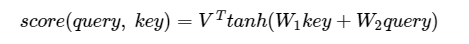

In [7]:
class BA(tf.keras.Model):
    def __init__(self,units):
        super(BA,self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
    
    def call(self,V,Q):
        hidden_with_time_axis = tf.expand_dims(Q,1)
        
        a_s = self.V(tf.nn.tanh(self.W1(V)+self.W2(hidden_with_time_axis)))
        a_w = tf.nn.softmax(a_s,axis=1)
        
        context_v = a_w * V
        context_v = tf.reduce_sum(context_v, axis=1)
        
        return context_v, a_w        

## 3. Bi LSTM + Attention 

In [8]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

### Input Layer & Embedding Layer

In [9]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len)(sequence_input)

In [10]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
    (LSTM
     (128,
      dropout=0.3,
      return_sequences=True,
      return_state=True,
      recurrent_activation='relu',
      recurrent_initializer='glorot_uniform'))(embedded_sequences)

Bidirectional LSTM을 사용할 경우에는 순방향 LSTM과 역방향 LSTM 각각 hidden & cell state를 가지므로, 이 두 방향의 LSTM state들을 concatenate 해줘야!
- forward_h & forward_c : 순방향 LSTM의 hidden & cell state
- backward_h & backward_c : 역방향 LSTM의 hidden & cell state

In [11]:
state_h = Concatenate()([forward_h, backward_h]) 
state_c = Concatenate()([forward_c, backward_c]) 

In [12]:
attention = BA(128) # weight

Encoder의 hidden state을 input으로 사용하여 context vector & attention weight 얻어냄

In [13]:
context_vector, attention_weights = attention(lstm, state_h)

In [14]:
hidden = BatchNormalization()(context_vector)

In [15]:
output = Dense(1, activation='sigmoid')(hidden)

In [16]:
model = Model(inputs=sequence_input, outputs=output)

clip norm : gradient의 L2 Norm이 clip norm보다 클 경우, 다음과 같이 clipping된 gradient를 이용

- clipping된 gradient = gradient * ( clipnorm / gradient L2 Norm )

In [17]:
Adam = optimizers.Adam(lr=0.0001, clipnorm=1.)

In [18]:
# 이진분류 문제이므로  binary_cross entropy(감성 분류)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train, 
                    epochs=2, batch_size=128, 
                    validation_data=(X_test, y_test), verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 5376/25000 [=====>........................] - ETA: 2:02:22 - loss: 0.6926 - accuracy: 0.5137

KeyboardInterrupt: 